<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<hr>

# 2.1.4 AC SAF Metop-B GOME-2 - Absorbing Aerosol Index (AAI) - Level 3

The data of the Metop-A/B/C GOME-2 `Absorbing Aerosol Index (AAI)` are provided by KNMI in the framework of the [EUMETSAT Satellite Application Facility on Atmospheric Composition Monitoring (AC SAF)](https://acsaf.org/index.php).

The Absorbing Aerosol Index (AAI) indicates the presence of elevated absorbing aerosols in the Earth's atmosphere. The aerosol types that are mostly seen in the AAI are desert dust and biomass burning aerosols. 

The web-based service for atmospheric satellite data products [TEMIS](http://www.temis.nl/airpollution/absaai/), maintained by KNMI, provides daily and monthly aggregated Level 3 (gridded) data products for the three satellites Metop-A, -B, and -C.

Find more information on the GOME-2 Level 3 AAI data product processed by KNMI [here](https://acsaf.org/datarecords/aai.php).

#### This module has the following outline:
* [1 - Load and browse AC SAF Metop-A GOME-2 Level 3 AAI data](#load_browse)
* [2 - Concatenate the data from the three satellites Metop-B](#concat)
* [3 - Retrieve  time coordinate information and assign time coordinates to the time dimension](assign_time_coord)
* [5 - Visualize AAI data with data from Metop-B combined on one single grid](#visualize)
* [6 - Animate daily AC SAF Metop-B GOME-2 Level 3 Absorbed Aerosol Index (AAI) data ](#animate)



#### Load required libraries

In [1]:
import xarray as xr
from datetime import datetime
import pandas as pd
import requests
import io

import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

from matplotlib import pyplot as plt
from matplotlib import animation

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import HTML

In [2]:
%run ../helper_functions.ipynb

In [3]:
base_url = "https://s3.waw3-2.cloudferro.com/swift/v1/act6/"

latmin = 30
latmax = 50
lonmin = 15
lonmax = 40

<hr>

## <a id='load_browse'></a>Load and browse AC SAF Metop-A GOME-2 Level 3 AAI data

The AC SAF Metop-A/B/C GOME-2 Level 3 AAI data files can be downloaded from the TEMIS website in `NetCDF` data format. TEMIS offers the data of all three satellites Metop-A, -B and -C, which, combined, provide daily measurements for the entire globe.

The following example uses daily gridded AAI data satellitesMetop-B for 3 consecutive days between `21 and 23 August 2023`. The example shows the dispersion of aerosols during the Greek fires in August 2023.

The daily gridded data is available for each satellite. Thus, a first step is to inspect one file to get a better understanding of the general data structure. Followed by loading the data files for the entire time period into one `xarray.DataArray`.

### Inspect the structure of one daily gridded AAI data file

Since the data is distributed in the `NetCDF` format, you can use the xarray function `xr.open_dataset()` to load one single file to better understand the data structure.

In [4]:
# Define the data path
data_path = "data/metop/gome2_aai/"
filename = "ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230821-fv1.9.nc"

# Stream the file content
response = requests.get(base_url + data_path + filename, stream=True)

# Ensure the request is successful
if response.status_code == 200:
    # Convert the streamed content into a file-like object
    file_obj = io.BytesIO(response.content)

    # Open the file with xarray as a NetCDF dataset
    file = xr.open_dataset(file_obj)
    print(f"File opened")
else:
    print(f"Failed to fetch file: {response.status_code}")

File opened


In [5]:
file

<xarray.Dataset> Size: 650kB
Dimensions:                  (longitude: 360, latitude: 180)
Coordinates:
  * longitude                (longitude) float32 1kB -179.5 -178.5 ... 179.5
  * latitude                 (latitude) float32 720B -89.5 -88.5 ... 88.5 89.5
Data variables:
    absorbing_aerosol_index  (longitude, latitude) float32 259kB ...
    number_of_observations   (longitude, latitude) int16 130kB ...
    solar_zenith_angle       (longitude, latitude) float32 259kB ...
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      ESA CCI absorbing aerosol index level 3 product
    description:                Multi-Sensor AAI field for 21-08-2023
    institution:                Royal Netherlands Meteorological Institute (K...
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-aerosol-cci.org
    ...                         ...
    geospatial_lon_resolution:  1.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    comment:                    Sun glint and solar eclipse events were filte...
    license:                    ESA CCI Data Policy: free and open access
    summary:                    This dataset contains absorbing aerosol index...

The output of the `xarray.Dataset` above shows that one file contains the data of three variables: <br>
* `absorbing_aerosol_index`,
* `number_of_observations`, and
* `solar_zenith_angle`. 

The variable of interest is `absorbing aerosol_index`. By adding the variable of interest into square brackets `[]`, you can select the data variable. Variables are stored as `xarray.DataArray`. You can see that the daily gridded data are on a 1 deg x 1 deg data grid, with 180 latitude values and 360 longitude values.

In [6]:
aai = file['absorbing_aerosol_index']
aai

<xarray.DataArray 'absorbing_aerosol_index' (longitude: 360, latitude: 180)> Size: 259kB
[64800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  absorbing aerosol index averaged for each grid cell
    units:      1

### Load a time-series of daily AC SAF Metop-B GOME-2 Level 3 AAI data into one `xarray.Dataset`

The xarray `open_mfdataset()` function allows the openening of multiple files at once. You have to specify the dimension the files shall be concatenated by. It can be an existing dimension within the data file or a new dimension, which is newly specified.

Let's open the daily gridded AAI data from Metop-A for the 3 days from 21 to 23 August 2023 and we specify `time` as a new dimension the data files shall be concatenated by.

After you loaded the multiple files in a `Dataset` with the function `open_mfdataset()`, you have to select again `absorbing_aerosol_index` as the variable of interest.

The resulting `xarray.DataArray` has three dimensions (`time`, `latitude` and `longitude`).


In [7]:
data_path = "data/metop/gome2_aai/"

# List of filenames
filenames = [
    "ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230821-fv1.9.nc",
    "ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230822-fv1.9.nc",
    "ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230823-fv1.9.nc"
]

# List to store file-like objects
file_objs = []

# Loop over filenames, download and store file-like objects
for filename in filenames:
    file_url = base_url + data_path + filename
    response = requests.get(file_url, stream=True)
    
    if response.status_code == 200:
        # Convert the streamed content into a file-like object and add to the list
        file_objs.append(io.BytesIO(response.content))
    else:
        print(f"Failed to fetch {filename}: {response.status_code}")

# Use xarray to open the datasets as a multi-file dataset
if file_objs:
    # Open multiple file-like objects using xarray
    datasets = [xr.open_dataset(file_obj) for file_obj in file_objs]
    ds_b = xr.concat(datasets, dim="time") 
else:
    print("No files were downloaded successfully.")

aai_b=ds_b['absorbing_aerosol_index']
aai_b

<xarray.DataArray 'absorbing_aerosol_index' (time: 3, longitude: 360,
                                             latitude: 180)> Size: 778kB
array([[[        nan,         nan,         nan, ..., -0.25283033,
         -0.18957669, -0.05952134],
        [        nan,         nan,         nan, ..., -0.23286152,
         -0.19321358, -0.07503253],
        [        nan,         nan,         nan, ..., -0.24307944,
         -0.19759807, -0.19302344],
        ...,
        [        nan,         nan,         nan, ..., -0.2523297 ,
         -0.21041812, -0.08030885],
        [        nan,         nan,         nan, ..., -0.26133293,
         -0.2343834 , -0.13492392],
        [        nan,         nan,         nan, ..., -0.30579013,
         -0.18976137, -0.1058718 ]],

       [[        nan,         nan,         nan, ..., -0.21577498,
         -0.16413686, -0.25432414],
        [        nan,         nan,         nan, ..., -0.18422225,
         -0.17315567, -0.22459716],
        [        nan,         nan,         nan, ..., -0.11675324,
         -0.16210933, -0.31069595],
...
        [        nan,         nan,         nan, ..., -0.4031594 ,
         -0.21737497, -0.21270153],
        [        nan,         nan,         nan, ..., -0.39366904,
         -0.19257207, -0.3432876 ],
        [        nan,         nan,         nan, ..., -0.2503915 ,
         -0.19778179, -0.222762  ]],

       [[        nan,         nan,         nan, ..., -0.0603057 ,
         -0.1298108 , -0.35877275],
        [        nan,         nan,         nan, ..., -0.06857532,
         -0.11174545, -0.3955225 ],
        [        nan,         nan,         nan, ..., -0.04648441,
         -0.10568429, -0.37498498],
        ...,
        [        nan,         nan,         nan, ..., -0.10682949,
         -0.16239136, -0.45282334],
        [        nan,         nan,         nan, ..., -0.08355381,
         -0.1389804 , -0.33321628],
        [        nan,         nan,         nan, ..., -0.06625508,
         -0.14852513, -0.34973606]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  absorbing aerosol index averaged for each grid cell
    units:      1

<br>

## <a id='assign_time_coord'></a>Retrieve  time coordinate information and assign time coordinates for the time dimension

By inspecting the metadata of the single data file `aai_b` we loaded at the beginning, you can see that the only metadata attribute that contains the valid time step is the `description` attribute.

The first step is to retrieve the metadata attribute `description` and split the resulting string object at the positions with a space. The day string is the fourth position of the resulting string.

The `description` attribute can be accessed directly from the `aai_gome2a` `Dataset` object.

In [17]:
start_day = ds_b.description.split()[4]
start_day

'21-08-2023'

With the help of the Python library `pandas`, you can build a `DateTime` time series for 24 consecutive days, starting from the `start_day` variable that was defined above.

You can use the `date_range` function from pandas, using the length of the time dimension of the `aai_concat` DataArray and `'d'` (for day) as freqency argument.

The result is a time-series with `DateTime` information from 28 December 2019 to 20 January 2020.

In [11]:
time_coords = pd.date_range(start_day, periods=len(aai_b.time), freq='d').strftime("%Y-%m-%d").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2023-08-21', '2023-08-22', '2023-08-23'], dtype='datetime64[ns]', freq=None)

The final step is to assign the pandas time series object `time_coords` to the `aai_concat` DataArray object. You can use the `assign_coords()` function from xarray.

The result is that the time coordinates have now been assigned values. The only dimension the remains unassigned is `satellite`.

In [12]:
aai_b = aai_b.assign_coords(time=time_coords)
aai_b

<xarray.DataArray 'absorbing_aerosol_index' (time: 3, longitude: 360,
                                             latitude: 180)> Size: 778kB
array([[[        nan,         nan,         nan, ..., -0.25283033,
         -0.18957669, -0.05952134],
        [        nan,         nan,         nan, ..., -0.23286152,
         -0.19321358, -0.07503253],
        [        nan,         nan,         nan, ..., -0.24307944,
         -0.19759807, -0.19302344],
        ...,
        [        nan,         nan,         nan, ..., -0.2523297 ,
         -0.21041812, -0.08030885],
        [        nan,         nan,         nan, ..., -0.26133293,
         -0.2343834 , -0.13492392],
        [        nan,         nan,         nan, ..., -0.30579013,
         -0.18976137, -0.1058718 ]],

       [[        nan,         nan,         nan, ..., -0.21577498,
         -0.16413686, -0.25432414],
        [        nan,         nan,         nan, ..., -0.18422225,
         -0.17315567, -0.22459716],
        [        nan,         nan,         nan, ..., -0.11675324,
         -0.16210933, -0.31069595],
...
        [        nan,         nan,         nan, ..., -0.4031594 ,
         -0.21737497, -0.21270153],
        [        nan,         nan,         nan, ..., -0.39366904,
         -0.19257207, -0.3432876 ],
        [        nan,         nan,         nan, ..., -0.2503915 ,
         -0.19778179, -0.222762  ]],

       [[        nan,         nan,         nan, ..., -0.0603057 ,
         -0.1298108 , -0.35877275],
        [        nan,         nan,         nan, ..., -0.06857532,
         -0.11174545, -0.3955225 ],
        [        nan,         nan,         nan, ..., -0.04648441,
         -0.10568429, -0.37498498],
        ...,
        [        nan,         nan,         nan, ..., -0.10682949,
         -0.16239136, -0.45282334],
        [        nan,         nan,         nan, ..., -0.08355381,
         -0.1389804 , -0.33321628],
        [        nan,         nan,         nan, ..., -0.06625508,
         -0.14852513, -0.34973606]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 24B 2023-08-21 2023-08-22 2023-08-23
Attributes:
    long_name:  absorbing aerosol index averaged for each grid cell
    units:      1

## <a id='visualize'></a>Visualize AAI data with data from the satellite Metop-B combined on one single grid

The next step is to visualize the Absorbing Aerosol Index data for one time step. You can use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh) for it.

You can use `afmhot_r` as color map, `ccrs.PlateCarree()` as projection and by applying `dt.strftime('%Y-%m-%d').data` to the time coordinate variable, you can add the valid time step to the title of the plot.

The resulting plot shows elevated AAI levels on the east coast of Australia on 28 December 2019.

(<Figure size 2000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'absorbing aerosol index averaged for each grid cell 2023-08-23'}>)

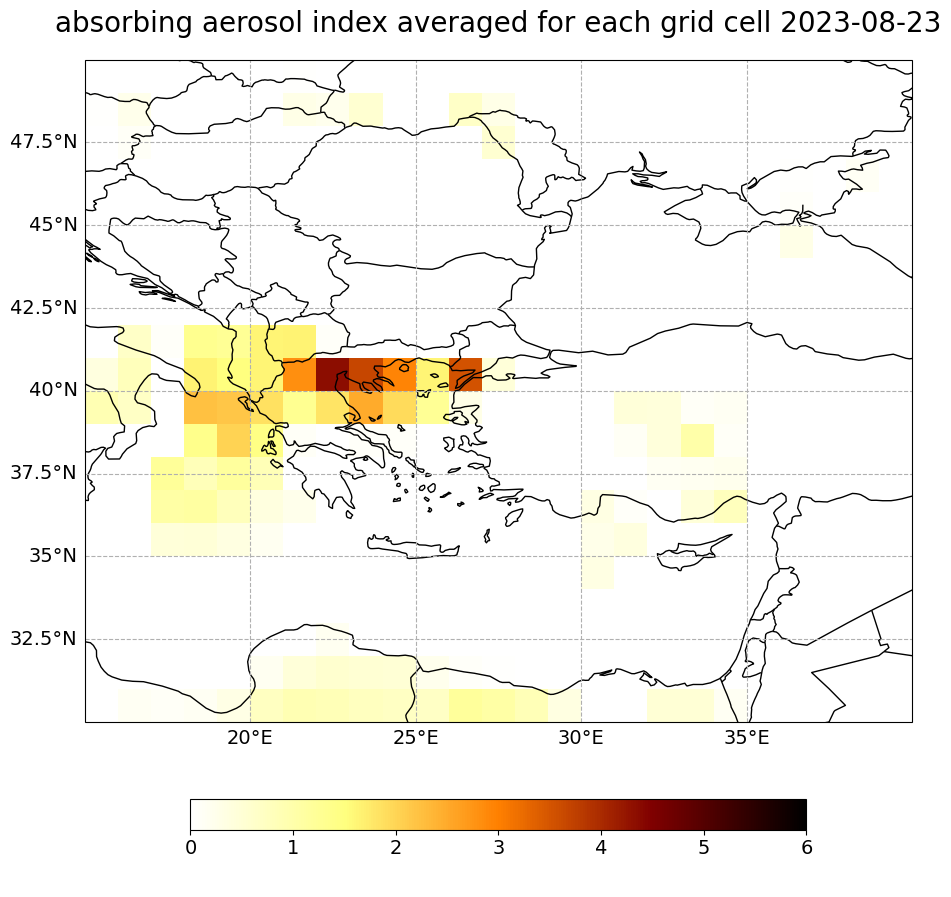

In [22]:
visualize_pcolormesh(data_array=aai_b[2,:,:].T,
                     longitude=aai_b.longitude, 
                     latitude=aai_b.latitude,
                     projection=ccrs.PlateCarree(), 
                     color_scale='afmhot_r', 
                     unit=' ',
                     long_name=aai_b.long_name +' ' + str(aai_b.time[2].dt.strftime('%Y-%m-%d').data), 
                     vmin=0, 
                     vmax=6,
                    latmin=latmin,
                     latmax=latmax,
                     lonmin=lonmin,
                     lonmax=lonmax,
                    set_global=False)


## <a id='animate'></a>Animate daily AC SAF Metop-B GOME-2 Level 3 Absorbing Aerosol Index (AAI) data between 28 December 2019 and 20 January 2020

The final step is now to animate the `aai_b` DataArray over the 3 days to see the dispersion of Aerosols resulting from biomass burning.

The animation function consists of four parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [33]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=aai_b[0,:,:].T,
                               longitude=aai_b.longitude, 
                               latitude=aai_b.latitude,
                               projection=ccrs.PlateCarree(), 
                               color_scale='afmhot_r', 
                               unit=' ',
                               long_name=aai_b.long_name + '/' + str(aai_b.time[0].dt.strftime('%Y-%m-%d').data), 
                               vmin=0, 
                               vmax=10, 
                               latmin=latmin,
                     latmax=latmax,
                     lonmin=lonmin,
                     lonmax=lonmax,
                    set_global=False)


frames = len(aai_b)

def draw(i):
    img = plt.pcolormesh(aai_b.longitude, 
                         aai_b.latitude, 
                         aai_b[i,:,:].T, 
                         cmap='afmhot_r', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=10)

    ax.set_extent([ lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    ax.set_title(aai_b.long_name + ' ' + str(aai_b.time[i].dt.strftime('%Y-%m-%d').data),
                fontsize=20, pad=20.0)
    return img

def init():
    return fig

def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)


#### Play the animation as HTML5 video

In [34]:
HTML(ani.to_html5_video())

<br>

### Additional informations

This notebook was adapted from:
[https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/214_Metop-ABC_GOME-2_AAI_L3_load_browse.ipynb?ref_type=heads](https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/214_Metop-ABC_GOME-2_AAI_L3_load_browse.ipynb?ref_type=heads)

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>